#### Import Libraries

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
import json

#### Load dataset

In [31]:
directory = 'data'
file_base = 'Merchants_Segments_01_'


# Generate the list of file names
files_names = [f'{file_base}{i}.json' for i in range(25, 32)] # last week of January 
# Generate the list of file directories
files = [os.path.join(directory, file_name) for file_name in files_names]

d =[]

# Load data from each JSON file
for file_name in files:
    with open(file_name, 'r') as file:
        for line in file:
            d.append(json.loads(line))

# Create a DataFrame
data = pd.DataFrame(d)

In [5]:
data.columns

Index(['trip_id', 'time_gap', 'dist', 'trip_time', 'driverID', 'weekID',
       'timeID', 'dateID', 'dist_gap', 'lats', 'lngs', 'time_offset',
       'merchant'],
      dtype='object')

#### Data Preprocessing

In [32]:
# Extract the first lat and lng as merchant coordinates
data['merchant_coords'] = list(zip(data['lats'].apply(lambda x: x[0]), data['lngs'].apply(lambda x: x[0])))

# Define the weekday column based on the dateID
data['weekday'] = data['dateID'].apply(lambda x: 1 if 27 <= x <= 30 else 0)

# Select and rename columns 
data = data[['trip_id', 'trip_time', 'driverID', 'timeID', 'dateID', 'weekday', 'merchant', 'merchant_coords']]
data = data.rename(columns={'trip_time': 'wait_time'})
data = data.rename(columns={'merchant': 'merchantID'})


In [33]:
# Step 1: Create the 'hour' column in 'data' by converting 'timeID' to hours
data['hour'] = data['timeID'] // 60

# Step 2: Calculate order frequency per hour for each merchantID and dateID
order_frequency = data.groupby(['merchantID', 'hour', 'dateID']).size().reset_index(name='order_frequency_per_hour')

# Step 3: Merge the order frequency data back to the original data on 'merchantid', 'hour', and 'dateID'
data = data.merge(order_frequency, on=['merchantID', 'hour', 'dateID'], how='left')

# Drop the 'hour' column if it's not needed in the final DataFrame
# data = data.drop(columns=['hour'])


In [8]:
data.columns

Index(['trip_id', 'wait_time', 'driverID', 'timeID', 'dateID', 'weekday',
       'merchantID', 'merchant_coords', 'order_frequency_per_hour'],
      dtype='object')

In [34]:
# Define function to assign periods based on timeID
def assign_time_period(time_id):
    if 0 <= time_id < 360:         # Midnight to 6 AM
        return 'night'
    elif 360 <= time_id < 720:      # 6 AM to Noon
        return 'morning'
    elif 720 <= time_id < 1080:     # Noon to 6 PM
        return 'afternoon'
    else:                           # 6 PM to Midnight
        return 'evening'

# Apply the function to create a new 'time_period' feature
data['time_period'] = data['timeID'].apply(assign_time_period)

# Option 1: Convert 'time_period' to ordinal integers
time_period_mapping = {'night': 0, 'morning': 1, 'afternoon': 2, 'evening': 3}
data['time_period'] = data['time_period'].map(time_period_mapping)


In [35]:
# Creating interaction terms between order_frequency_per_hour and weekday
data['order_weekday_interaction'] = data['order_frequency_per_hour'] * data['weekday']


In [36]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Separate 'merchant_coords' into 'merchant_lat' and 'merchant_lon'
data[['merchant_lat', 'merchant_lon']] = pd.DataFrame(data['merchant_coords'].tolist(), index=data.index)

# Step 2: Encode 'merchantID' as a categorical feature
data['merchantID'] = LabelEncoder().fit_transform(data['merchantID'])

# If 'driverID' is also needed in the model, encode it similarly
data['driverID'] = LabelEncoder().fit_transform(data['driverID'])

# Convert 'weekday' column to boolean
data['weekday'] = data['weekday'].astype(bool)

In [37]:
center_lat, center_lon = 31.96316667, 35.93036111  #down town Amman

# Calculate Euclidean distance from the central point
data['merchant_distance_from_center'] = np.sqrt((data['merchant_lat'] - center_lat)**2 + (data['merchant_lon'] - center_lon)**2)

In [38]:
data['merchantID_encoded'] = data.groupby('merchantID')['wait_time'].transform('mean')
data['driverID_encoded'] = data.groupby('driverID')['wait_time'].transform('mean')

In [52]:
data = data[data['wait_time'] <= 3000]

In [59]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 34985 entries, 0 to 35008
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   trip_id                        34985 non-null  object 
 1   wait_time                      34985 non-null  float64
 2   driverID                       34985 non-null  int64  
 3   timeID                         34985 non-null  int64  
 4   dateID                         34985 non-null  int64  
 5   weekday                        34985 non-null  bool   
 6   merchantID                     34985 non-null  int64  
 7   merchant_coords                34985 non-null  object 
 8   hour                           34985 non-null  int64  
 9   order_frequency_per_hour       34985 non-null  int64  
 10  time_period                    34985 non-null  int64  
 11  order_weekday_interaction      34985 non-null  int64  
 12  merchant_lat                   34985 non-null  floa

In [58]:
# Calculate variance of 'time' and count of rows for each group defined by 'merchantID', 'hour', and 'weekday'
variance_df = data.groupby(['merchantID', 'hour', 'weekday','driverID','time_period','dateID']).agg(
    food_prep_variance=('food_preparation_time', 'var'),
    wait_time_variance=('wait_time', 'var'),
    row_count=('wait_time', 'size'),  # Counting rows in each group
    trip_ids=('trip_id', lambda x: list(x)),        # List of trip IDs
    times=('wait_time', lambda x: list(x))               # List of times
    # date=('dateID', lambda x: list(x)) 
).reset_index()

# Save the results to a CSV file
variance_df.to_csv('merchant_variance_by_groups.csv', index=False)

print("Variance and row count data saved to 'merchant_variance_by_groups.csv'")


Variance and row count data saved to 'merchant_hour_weekday_variance_and_count.csv'


#### Train/Test Split

In [53]:
feature_columns = ['merchant_distance_from_center',  'order_frequency_per_hour', 'merchantID_encoded', 'driverID_encoded', 'time_period', 'order_weekday_interaction','food_preparation_time'] 
target_column = 'wait_time'

X = data[feature_columns]
y = data[target_column]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

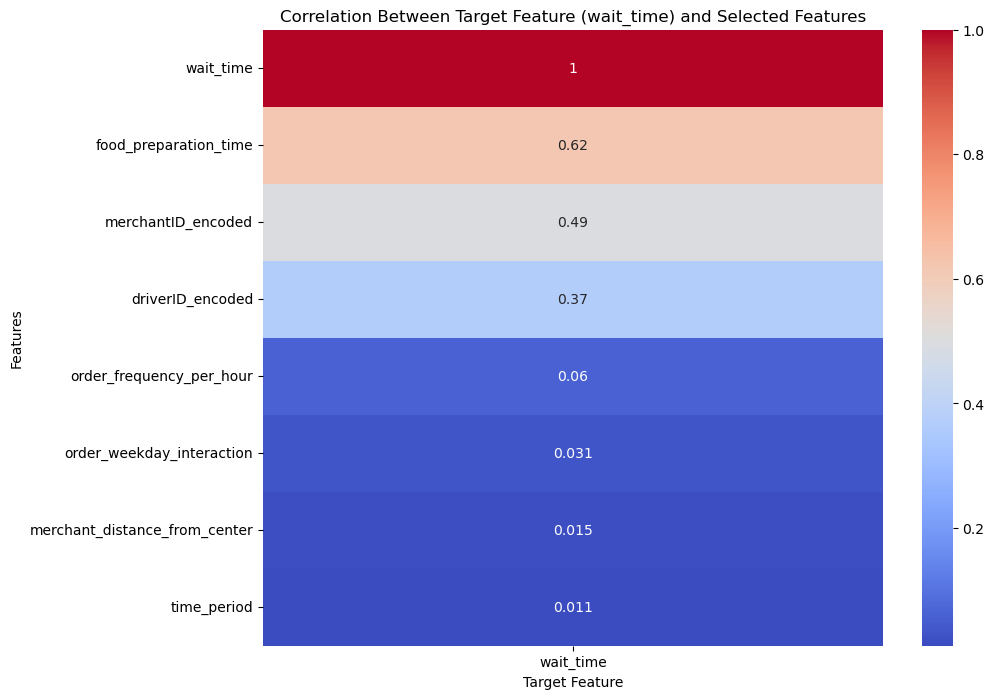

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the specified features and target column
selected_columns = feature_columns + [target_column]
data_selected = data[selected_columns]

# Calculate the correlation matrix for the selected columns
correlation_matrix = data_selected.corr()

# Plot the correlation between the target feature and other features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[[target_column]].sort_values(by=target_column, ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation Between Target Feature (wait_time) and Selected Features")
plt.xlabel("Target Feature")
plt.ylabel("Features")
plt.show()

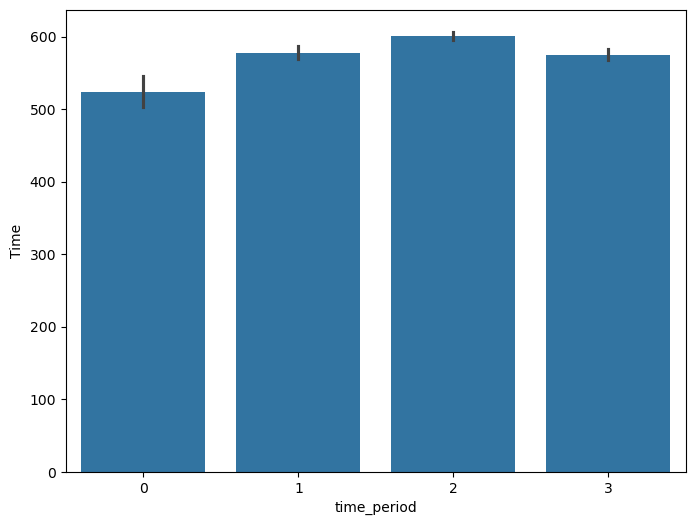

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'weekend' is a boolean column and 'time' is the target variable
plt.figure(figsize=(8, 6))
sns.barplot(x='time_period', y='wait_time', data=data)
# plt.title('Box Plot of Time by Weekend')
plt.xlabel('time_period')
plt.ylabel('Time')
plt.show()


#### XGBoost

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',  
    n_estimators=1500,              
    learning_rate=0.005,             
    max_depth=6,                   
    random_state=42,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.5,
    reg_lambda=1,   
    subsample=0.6
)


# Train the model
xgboost_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgboost_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) 


print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared (R2): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Squared Error (MSE): 64543.77777833287
Root Mean Squared Error (RMSE): 254.0546747814983
Mean Absolute Error (MAE): 192.6145518202502
R-Squared (R2): 0.5689739075952589
Mean Absolute Percentage Error (MAPE): 0.49488225200083136


#### feature importance

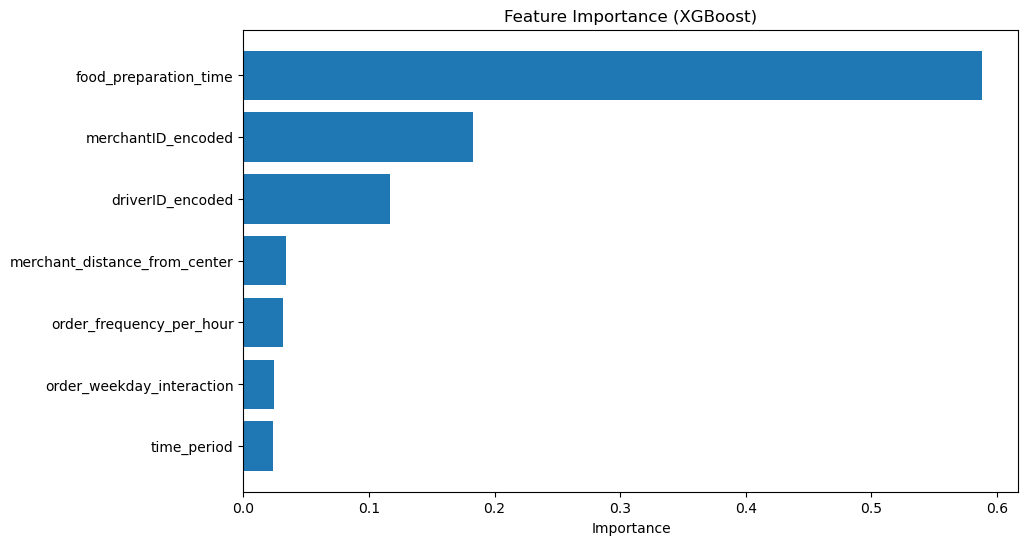

In [56]:
import matplotlib.pyplot as plt
feature_importances = xgboost_model.feature_importances_
features = X_train.columns

# Create a DataFrame to sort and plot feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # Optional: invert y-axis for descending order
plt.show()


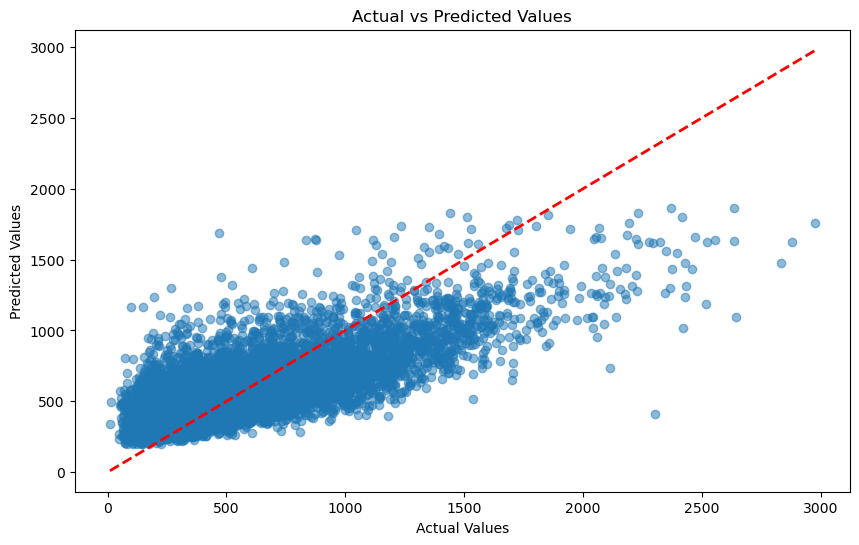

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line for perfect prediction
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


##### grid search

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

# Define a custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Use the custom RMSE function with make_scorer
scoring = make_scorer(rmse, greater_is_better=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring=scoring,    # Use 'accuracy' for classification tasks
    cv=3,               # 3-fold cross-validation
    verbose=1,
    n_jobs=-1           # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X, y)

# Print the best parameters and best RMSE score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE Score:", -grid_search.best_score_)

Fitting 3 folds for each of 20736 candidates, totalling 62208 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.8}
Best RMSE Score: 371.7058182914136


#### SVR

In [87]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error# Scale the features for SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Scale the features for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the SVR model
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svr_model.predict(X_test_scaled)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared (R2): {r2}")

Mean Squared Error (MSE): 156055.1516594632
Root Mean Squared Error (RMSE): 395.0381648138104
Mean Absolute Error (MAE): 286.9171212703529
R-Squared (R2): -0.05139229039641324


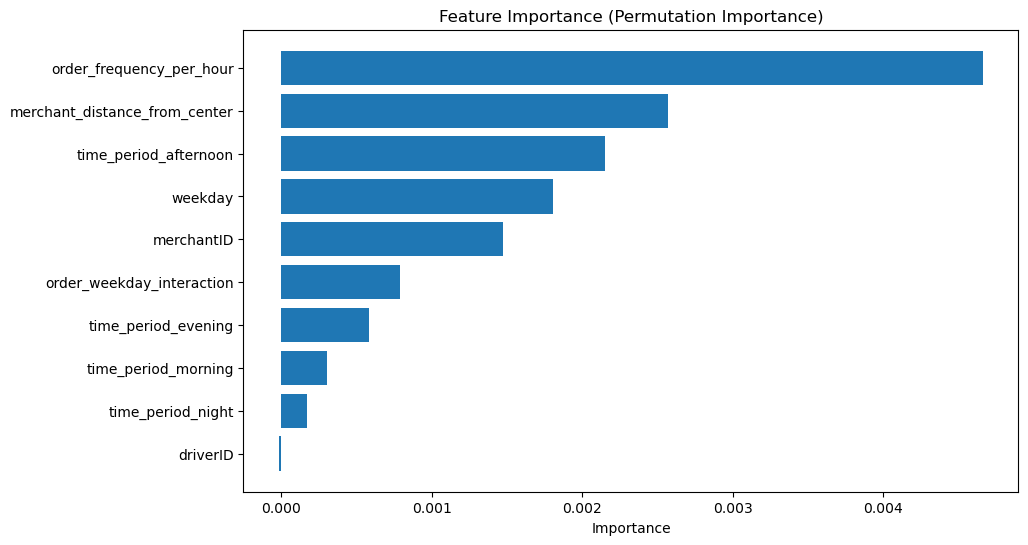

In [88]:
# Calculate Permutation Feature Importance
perm_importance = permutation_importance(svr_model, X_test_scaled, y_test, n_repeats=5, random_state=42)

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (SVR)')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()

#### Decision Tree

In [82]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42, max_depth=5)  # Adjust max_depth as needed
tree_model.fit(X_train, y_train)

# Predict on the test set
y_pred = tree_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared (R2): {r2}")


Mean Squared Error (MSE): 141965.97345939904
Root Mean Squared Error (RMSE): 376.7837223917709
Mean Absolute Error (MAE): 286.6760034359491
R-Squared (R2): 0.056662729370587916


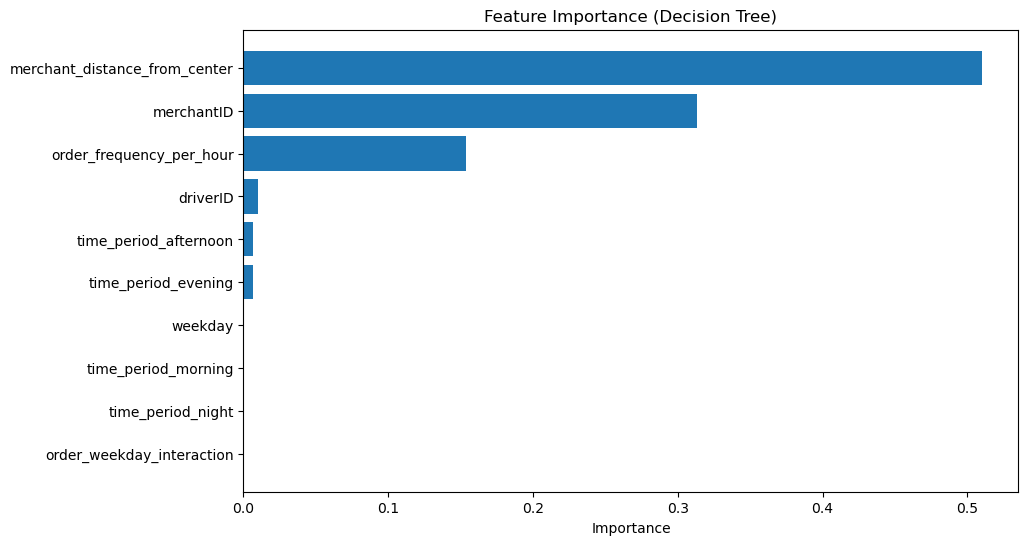

In [83]:
# Feature Importance Plot
feature_importance = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance.index, feature_importance.values)
plt.xlabel("Importance")
plt.title("Feature Importance (Decision Tree)")
plt.gca().invert_yaxis()  # For descending order
plt.show()

#### RFR

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rfr_model = RandomForestRegressor(
    n_estimators=100,    # Number of trees
    max_depth=10,        # Maximum depth of each tree
    random_state=42,
    n_jobs=-1            # Use all available cores
)

# Train the model
rfr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rfr_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared (R2): {r2}")


Mean Squared Error (MSE): 128499.52859474016
Root Mean Squared Error (RMSE): 358.46830905219525
Mean Absolute Error (MAE): 271.6852577076195
R-Squared (R2): 0.13425854739547427


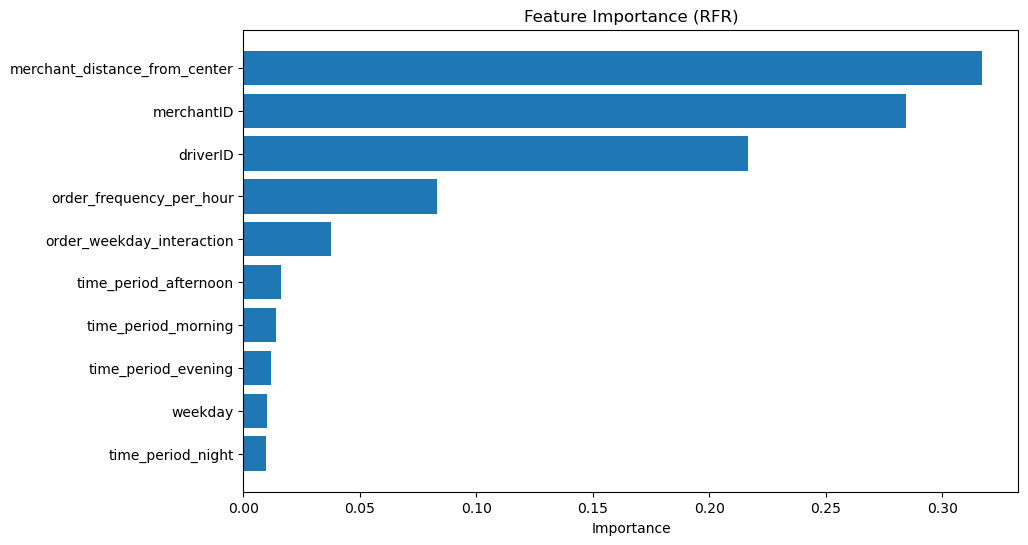

In [20]:
# Feature Importance
feature_importance = pd.Series(rfr_model.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.index, feature_importance.values)
plt.xlabel("Importance")
plt.title("Feature Importance (RFR)")
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()